## 项目背景
###     对全球最大的P2P平台lendingclub的历史借贷数据进行分析,从数据中直观了解贷款群体,并使用机器学习算法, 构建贷款预测模型,可以对新增贷款人进行预测,作为是否对其放贷的依据

## 项目分析思路
### 数据准备-数据预处理-数据的探索分析-特征处理-特征选择-建立模型-模型评估

## 数据准备

In [1]:
#导入相关包
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msn
%matplotlib inline
warnings.filterwarnings("ignore")

In [83]:
#csv文件
os.listdir("./data")

['.DS_Store',
 'LoanStats_2016Q3.csv',
 'LoanStats_2016Q2.csv',
 'LoanStats_2016Q1.csv',
 'LoanStats_2016Q4.csv',
 'LoanStats3b.csv',
 'LoanStats3c.csv',
 'LoanStats3a.csv']

In [84]:
#读取文件并合并
#文件标准的情况下也可以将所有csv文件合并为一个csv文件
#!cat ./data/*.csv > all.csv
def read_csv(filename):
    return pd.read_csv(filename,skiprows=1,encoding="utf8")

a = read_csv("./data/LoanStats_2016Q3.csv")
b = read_csv("./data/LoanStats_2016Q2.csv")
c = read_csv("./data/LoanStats_2016Q1.csv")
d = read_csv("./data/LoanStats_2016Q4.csv")
e = read_csv("./data/LoanStats3b.csv")
f = read_csv("./data/LoanStats3a.csv")
g = read_csv("./data/LoanStats3c.csv")
data = pd.concat([a,b,c,d,e,f,g],axis=0)

print(data.shape)
data.head()

(707674, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,15000.0,15000.0,15000.0,36 months,13.99%,512.60,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,14000.0,14000.0,14000.0,36 months,14.49%,481.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,7000.0,7000.0,7000.0,36 months,7.59%,218.04,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4200.0,4200.0,4200.0,36 months,8.59%,132.76,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,18000.0,18000.0,18000.0,36 months,8.59%,568.97,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 数据预处理

In [85]:
#统计缺失值占比
thred = data.isnull().sum(axis=0).sort_values(ascending=False)/float(len(data))
thred[thred>0.3]

sec_app_revol_util                            1.000000
sec_app_open_acc                              1.000000
member_id                                     1.000000
url                                           1.000000
sec_app_open_act_il                           1.000000
revol_bal_joint                               1.000000
sec_app_earliest_cr_line                      1.000000
sec_app_inq_last_6mths                        1.000000
sec_app_num_rev_accts                         1.000000
sec_app_chargeoff_within_12_mths              1.000000
sec_app_collections_12_mths_ex_med            1.000000
sec_app_mths_since_last_major_derog           1.000000
sec_app_mort_acc                              1.000000
id                                            0.999977
orig_projected_additional_accrued_interest    0.996541
hardship_length                               0.995617
hardship_end_date                             0.995617
hardship_start_date                           0.995617
hardship_a

In [86]:
#删除缺失值占比超过30%的列
thresh_count = len(data)*0.3
data = data.dropna(thresh=thresh_count,axis=1)

#数据类型统计
data.dtypes.value_counts()

float64    78
object     25
dtype: int64

In [87]:
#删除特征单一字段
data = data.loc[:,data.apply(pd.Series.nunique)!=1]
data.shape

(707674, 102)

In [88]:
#分类变量缺失值填充
objectColumns = data.select_dtypes(include=["object"]).columns
data[objectColumns].head(2)

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,...,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,13.99%,C,C3,Fiscal Director,2 years,RENT,Not Verified,Sep-2016,Current,...,Jan-1996,57.8%,f,Feb-2018,Mar-2018,Feb-2018,Individual,N,Cash,N
1,36 months,14.49%,C,C4,Postdoctoral Researcher,2 years,RENT,Source Verified,Sep-2016,Fully Paid,...,Sep-2004,87.2%,w,Dec-2017,NaN,Jan-2018,Individual,N,Cash,N


In [89]:
#类型转换
data["int_rate"] = data["int_rate"].str.rstrip("%").astype("float")
data["revol_util"] = data["revol_util"].str.rstrip("%").astype("float")
#显示分类变量
objectColumns = data.select_dtypes(include=["object"]).columns
objectColumns

<Figure size 1008x504 with 0 Axes>

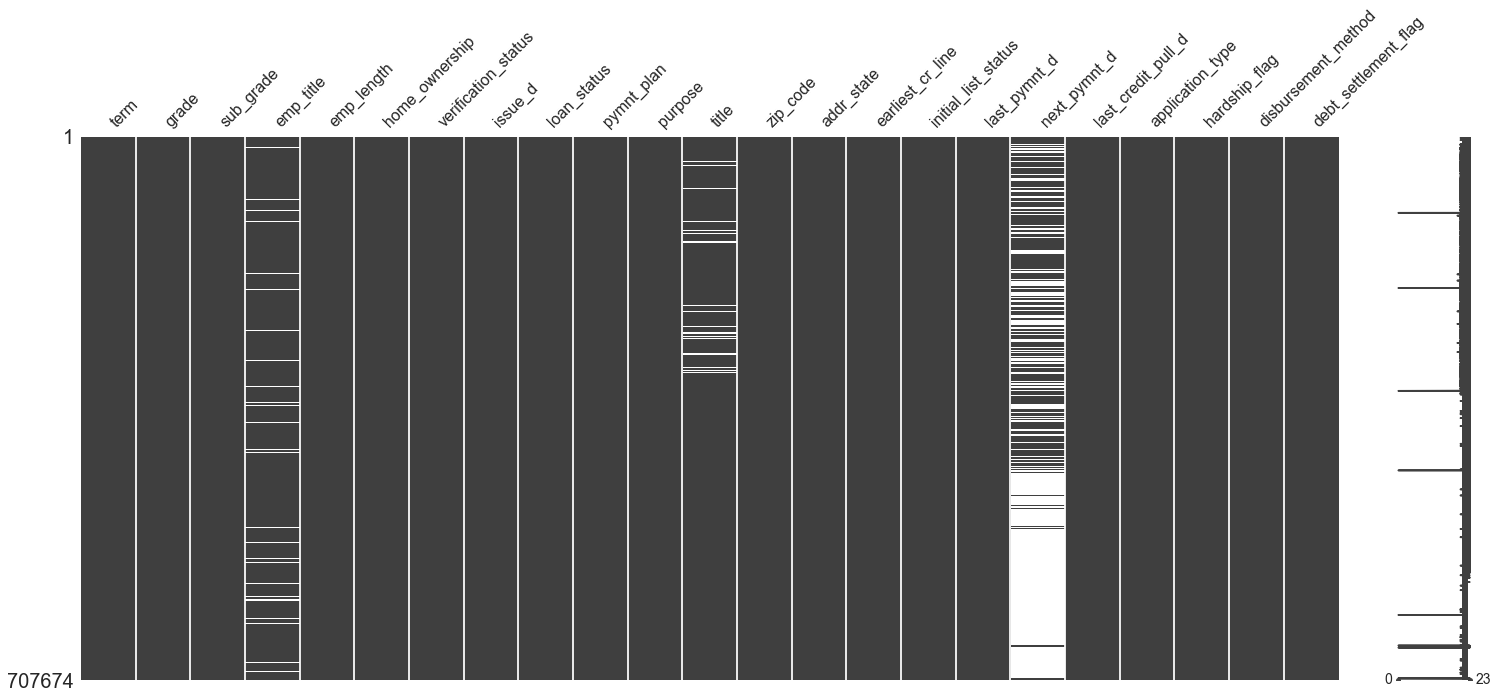

In [91]:
plt.figure(figsize=(14,7))
msn.matrix(data[objectColumns])

#### 缺失值最多的列依次是 next_pymnt_d, sub_grade,title, 缺失值最多得行是23行, 最少的是0行.

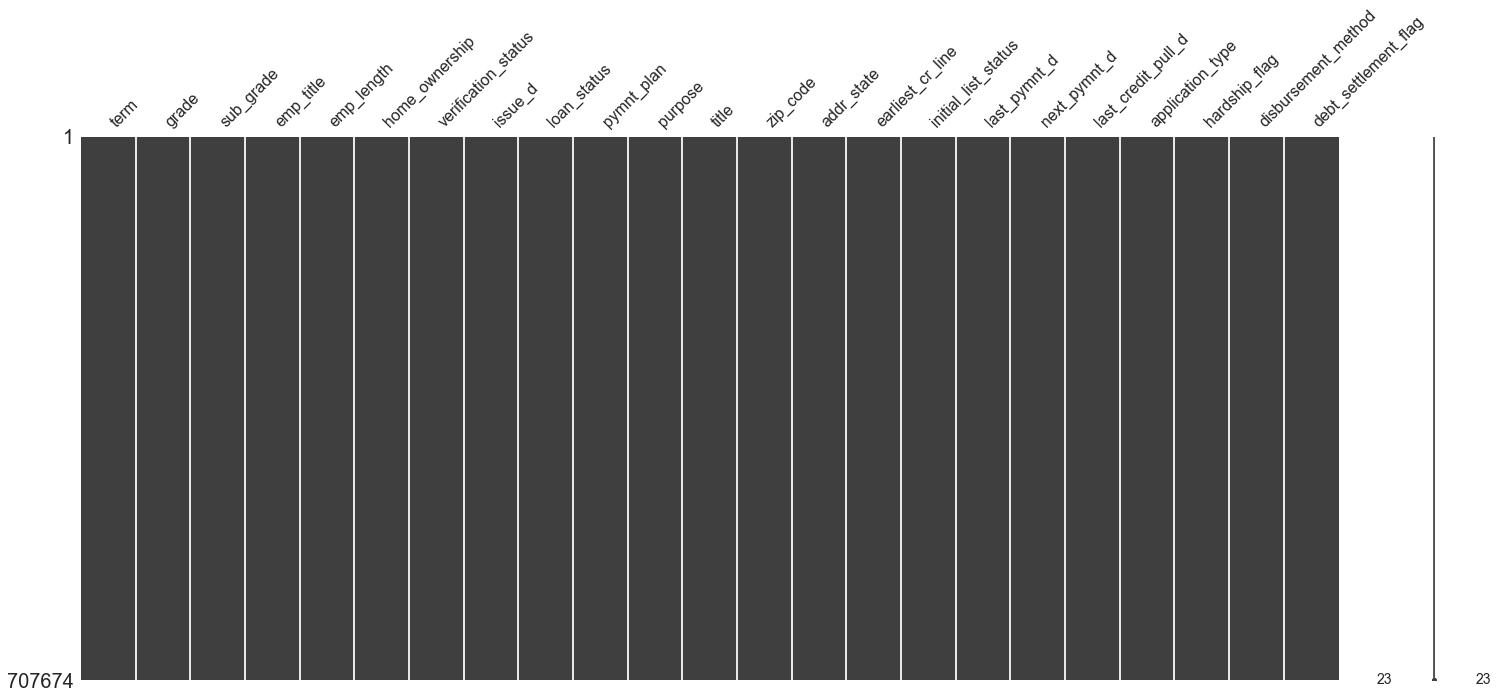

In [92]:
#缺失值填充
data[objectColumns] = data[objectColumns].fillna("unkonwn")
msn.matrix(data[objectColumns])

<Figure size 1080x504 with 0 Axes>

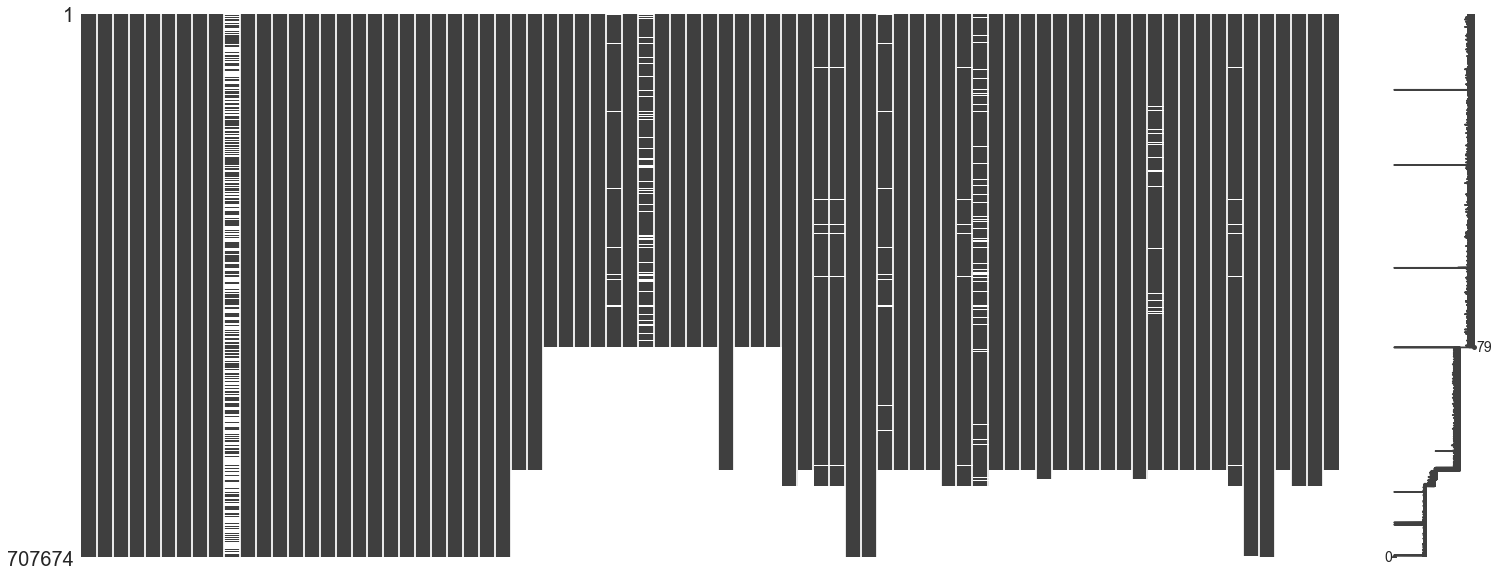

In [93]:
#数值型变量
numColumns = data.select_dtypes(include=["float","int64"]).columns
#缺失值可视化
plt.figure(figsize=(15,7))
msn.matrix(data[numColumns])

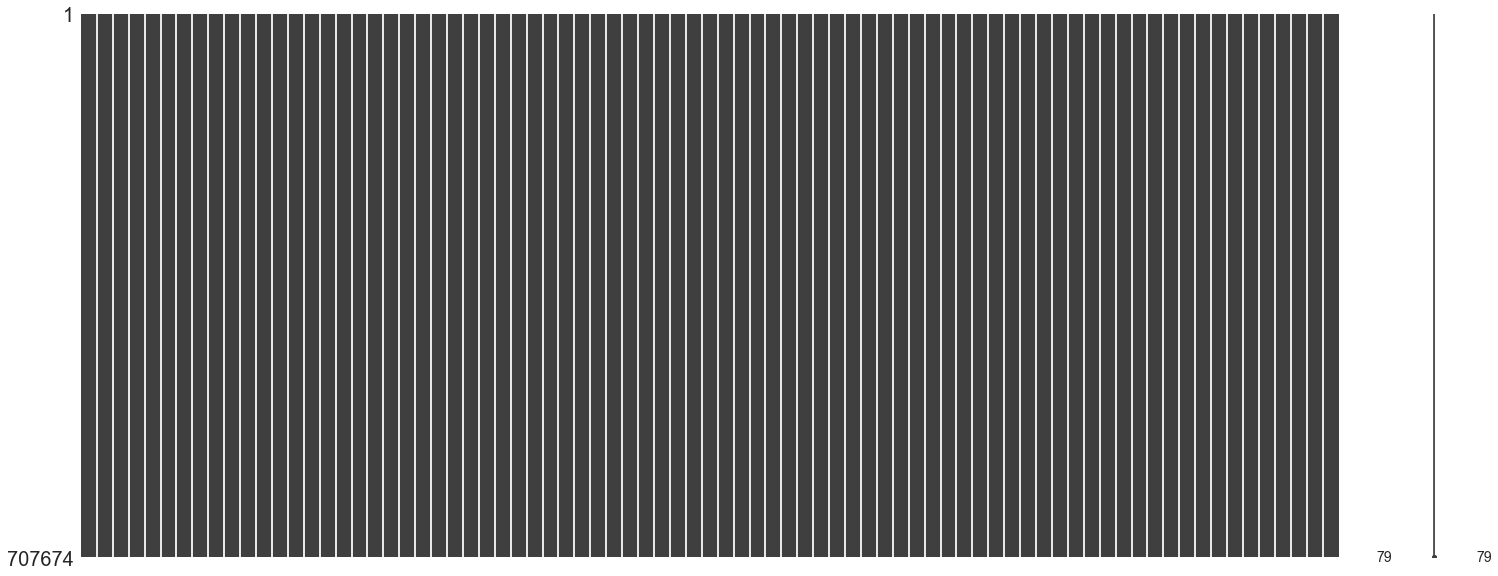

In [94]:
#均值填充
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values="NaN",strategy='mean',axis=0)
imr = imr.fit(data[numColumns])
data[numColumns] = imr.transform(data[numColumns])
msn.matrix(data[numColumns])

In [95]:
#删除重复行
print("删除前行数:",data.shape[0])

data = data.drop_duplicates()

print("删除后行数:",data.shape[0])

删除前行数: 707674
删除后行数: (665124, 102)


## 数据探索分析

In [103]:
#分类特征
data[objectColumns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665124 entries, 0 to 42535
Data columns (total 23 columns):
term                    665124 non-null object
grade                   665124 non-null object
sub_grade               665124 non-null object
emp_title               665124 non-null object
emp_length              665124 non-null object
home_ownership          665124 non-null object
verification_status     665124 non-null object
issue_d                 665124 non-null object
loan_status             665124 non-null object
pymnt_plan              665124 non-null object
purpose                 665124 non-null object
title                   665124 non-null object
zip_code                665124 non-null object
addr_state              665124 non-null object
earliest_cr_line        665124 non-null object
initial_list_status     665124 non-null object
last_pymnt_d            665124 non-null object
next_pymnt_d            665124 non-null object
last_credit_pull_d      665124 non-null obje

In [104]:
#数值特征
data[numColumns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665124 entries, 0 to 42535
Data columns (total 79 columns):
loan_amnt                     665124 non-null float64
funded_amnt                   665124 non-null float64
funded_amnt_inv               665124 non-null float64
int_rate                      665124 non-null float64
installment                   665124 non-null float64
annual_inc                    665124 non-null float64
dti                           665124 non-null float64
delinq_2yrs                   665124 non-null float64
inq_last_6mths                665124 non-null float64
mths_since_last_delinq        665124 non-null float64
open_acc                      665124 non-null float64
pub_rec                       665124 non-null float64
revol_bal                     665124 non-null float64
revol_util                    665124 non-null float64
total_acc                     665124 non-null float64
out_prncp                     665124 non-null float64
out_prncp_inv             

In [105]:
#数值变量
data[numColumns].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,665124.0,14393.498874,8701.795046,5.000000e+02,7800.000000,12000.000000,20000.000000,4.000000e+04
funded_amnt,665124.0,14375.596411,8693.856838,5.000000e+02,7800.000000,12000.000000,20000.000000,4.000000e+04
funded_amnt_inv,665124.0,14324.539314,8709.246083,0.000000e+00,7629.534292,12000.000000,20000.000000,4.000000e+04
int_rate,665124.0,13.335886,4.766972,5.320000e+00,9.750000,12.850000,15.990000,3.099000e+01
installment,665124.0,436.230173,261.140919,4.930000e+00,246.910000,375.430000,577.000000,1.584900e+03
annual_inc,665124.0,76780.218491,70257.345682,0.000000e+00,46000.000000,65000.000000,91000.000000,9.573072e+06
dti,665124.0,18.003005,9.590832,-1.000000e+00,11.710000,17.450000,23.730000,9.990000e+02
delinq_2yrs,665124.0,0.313037,0.866082,0.000000e+00,0.000000,0.000000,0.000000,2.900000e+01
inq_last_6mths,665124.0,0.663218,0.979384,0.000000e+00,0.000000,0.000000,1.000000,3.300000e+01
mths_since_last_delinq,665124.0,34.015639,15.303417,0.000000e+00,31.000000,34.038614,34.038614,1.950000e+02


In [176]:
#截取月份
data["month"] = data["issue_d"].apply(lambda x:x[0:3])

<Figure size 1008x504 with 0 Axes>

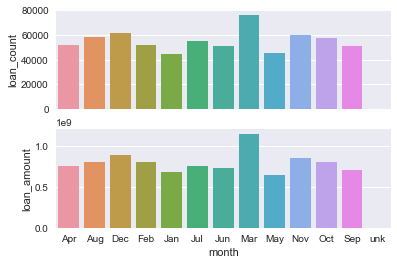

In [179]:
#放款笔数, 金额, 月份
df = data.groupby('month')['loan_amnt'].agg(['count','sum'])

fig = plt.figure(figsize=(14,7))
f,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
x = df.index
y1 = df['count']
sns.barplot(x, y1, ax=ax1)
y2 = df['sum']
ax1.set_xlabel("")
ax1.set_ylabel("loan_count")
sns.barplot(x, y2,ax=ax2)
ax2.set_ylabel("loan_amount")
sns.despine(bottom=True)

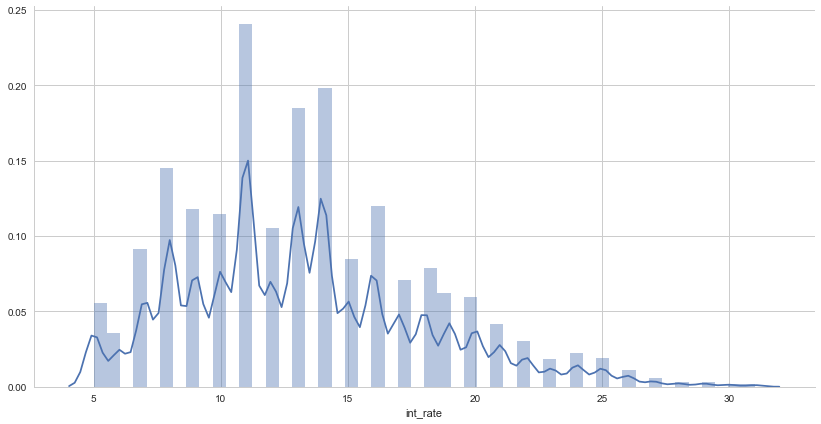

In [214]:
#贷款利率分布int_rate
plt.figure(figsize=(14,7))
sns.distplot(round(data.int_rate),kde=True)
sns.despine(top=True)

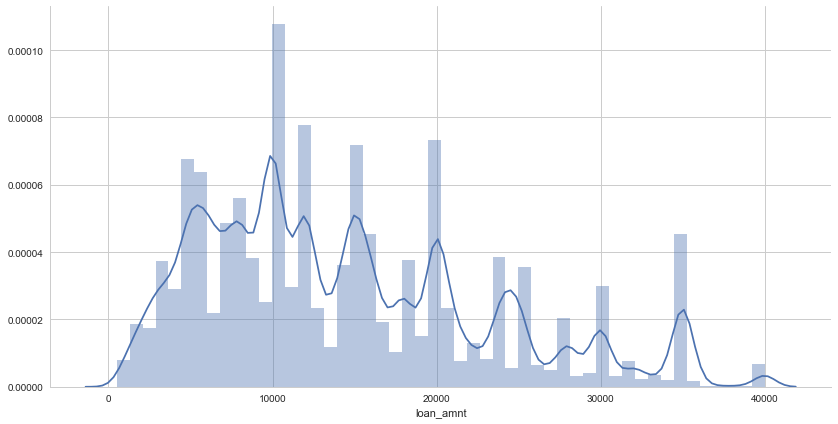

In [216]:
#贷款金额分布int_rate
plt.figure(figsize=(14,7))
sns.distplot(data.loan_amnt.astype("int"),kde=True)
sns.despine(top=True)

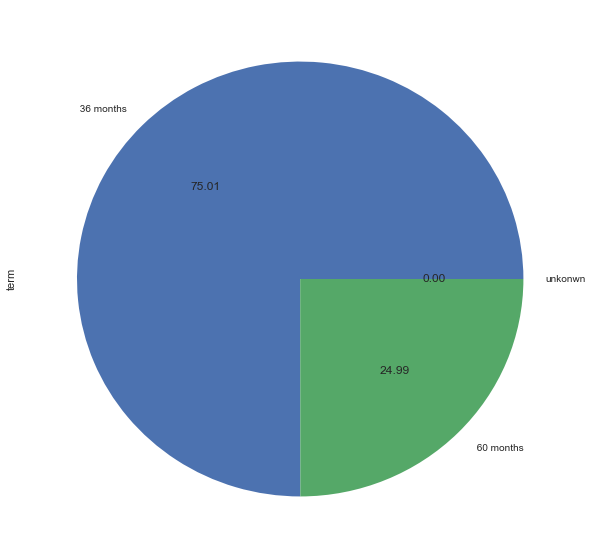

In [196]:
#期数分布
data.term.value_counts().plot.pie(autopct="%.2f",figsize=(10,10))

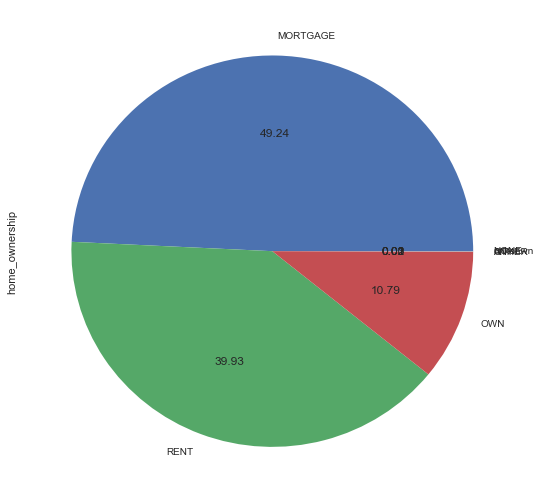

In [217]:
#住房情况
data.home_ownership.value_counts().plot.pie(autopct="%.2f",figsize=(9,9))

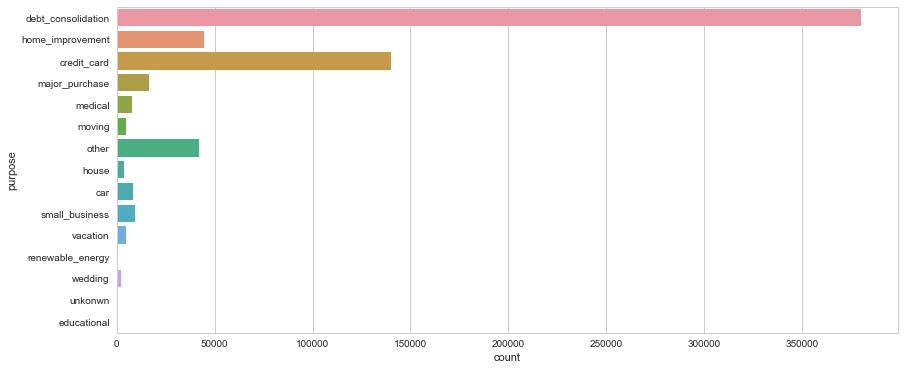

In [218]:
#贷款用途
plt.figure(figsize=(14,6))
sns.countplot(y=data.purpose)

## 特征处理

In [220]:
#删除不相关特征
for var in objectColumns:
    print(data[var].value_counts())

 36 months    498921
 60 months    166202
unkonwn            1
Name: term, dtype: int64
B          209524
C          190927
A          109610
D           93086
E           41445
F           16343
G            4188
unkonwn         1
Name: grade, dtype: int64
B4         46086
C1         45037
B3         44513
B5         43288
C2         39376
B2         38929
C4         36893
C3         36819
B1         36708
C5         32802
A5         27629
A4         24652
A1         24117
D1         23548
D2         21864
D3         17263
A3         16742
D4         16605
A2         16470
D5         13806
E1         10917
E2          8861
E3          8317
E4          7242
E5          6108
F1          4864
F2          3836
F3          3078
F4          2496
F5          2069
G1          1358
G2          1018
G3           758
G4           575
G5           479
unkonwn        1
Name: sub_grade, dtype: int64
unkonwn                                     42851
Teacher                                      9081


Name: addr_state, dtype: int64
Oct-2001    4439
Sep-2003    4438
Oct-2000    4379
Aug-2001    4333
Oct-2002    4271
Oct-2003    4257
Aug-2000    4240
Aug-2003    4231
Sep-2004    4215
Sep-2002    4179
Nov-2000    4144
Aug-2002    4136
Nov-1999    4091
Oct-2004    4031
Oct-1999    4030
Sep-2005    3980
Aug-2004    3918
Sep-2000    3901
Sep-2001    3809
Jul-2003    3779
Nov-2001    3716
Dec-2001    3711
Aug-2005    3699
Nov-2002    3664
Dec-2000    3655
Sep-1999    3645
Nov-2004    3604
Aug-1999    3583
Dec-1999    3563
Jul-2001    3555
            ... 
Jul-1955       1
May-1960       1
Jun-1952       1
Jun-1961       1
Jun-1958       1
Oct-1958       1
Nov-1957       1
Nov-1954       1
May-1953       1
Jun-1957       1
Oct-1957       1
Jul-1952       1
Nov-1953       1
Nov-1950       1
Dec-1956       1
Feb-1962       1
Dec-1946       1
Jan-1952       1
Mar-1957       1
Jul-1960       1
Jan-1946       1
Jan-1948       1
Mar-1960       1
Feb-1945       1
Mar-1954       1
Feb-1957       1


#### sub_grade 与grade重复且太过于分散, emp_title 缺失值较多, 种类较多, 无法真实反映借款人的还贷意愿,issue_d放款月份,时间维度,无法预测模型,pymnt_plan 单一同值,特征信息价值不高, title 过于分散,zip_code地址编码,addr_state地址,earliest_cr_line 第一笔借贷时间, 与结果没太多关系, last_pymnt_d同上, next_pymnt_d同上,last_credit_pull_d同上,hardship_flag同值化,debt_settlement_flag同值化,disbursement_method同值化,application_type同质化.

In [222]:
drop_columns = ["sub_grade","emp_title","issue_d","earliest_cr_line","last_pymnt_d","next_pymnt_d","last_credit_pull_d",
                "hardship_flag","debt_settlement_flag","disbursement_method","application_type","zip_code","title","purpose"
               ,"addr_state","pymnt_plan"]
data = data.drop(drop_columns,axis=1)

data.shape

In [225]:
data.shape

(665124, 92)

In [226]:
#特征衍生
#月均负债
data["installment_feat"] = data['installment']/(data['annual_inc']/12)

In [230]:
#标签处理
print(data.loan_status.value_counts())

dict_map = {"Fully Paid":0,"Current":0,"Charged Off":1,"Late (31-120 days)":1,"In Grace Period":1,
           "Does not meet the credit policy. Status:Fully Paid":1,"Late (16-30 days)":1,
           "Does not meet the credit policy. Status:Charged Off":0,"Default":0,"unkonwn":0}
#替换
data["loan_status"] = data["loan_status"].replace(dict_map)

0    572841
1     92283
Name: loan_status, dtype: int64

Text(0.5,1,'Percentage of earch loan status')

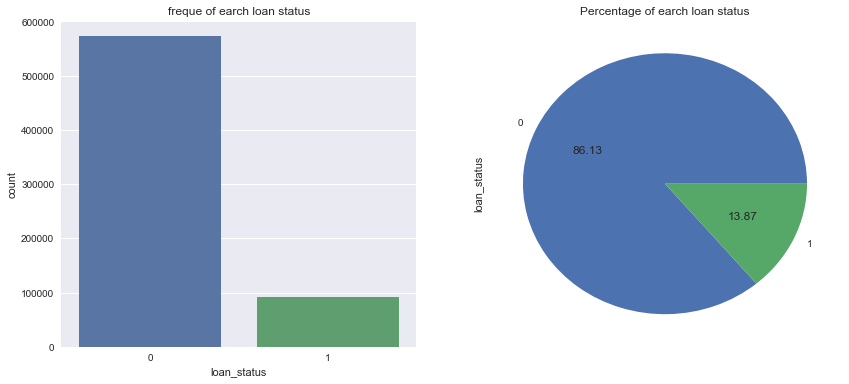

In [237]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
sns.countplot(x = data.loan_status,data=data,ax=axs[0])
axs[0].set(title="freque of earch loan status")
data["loan_status"].value_counts().plot.pie(autopct="%.2f",ax=axs[1])
axs[1].set_title("Percentage of earch loan status")

In [277]:
#分类变量编码
#有序变量编码
for var in data.select_dtypes(include=["object"]).columns:
    print(data[var].value_counts())

 36 months    498913
 60 months    166201
Name: term, dtype: int64
10+ years    220536
3             60489
3 years       53065
1             50203
5 years       44203
2             44185
4 years       40315
0             37212
6 years       32949
8 years       29318
7 years       27289
9 years       25350
Name: emp_length, dtype: int64
MORTGAGE    327484
RENT        265546
OWN          71742
OTHER          182
ANY            110
NONE            50
Name: home_ownership, dtype: int64
Verified           227142
Source Verified    226562
Not Verified       211410
Name: verification_status, dtype: int64
w    373544
f    291570
Name: initial_list_status, dtype: int64


In [282]:
map_dict = {"grade":{"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7},
           "emp_length":{"n/a":0,"< 1 year":1,"1 year":2,"2 years":3,"3 years":4,"4 years":5,"5 years":6,
                         "6 years":7,"7 years":8,"8 years":9,"9 years":10,
                        "10+ years":11},
            "month":{"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,"Jul":7,
                     "Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}}
data = data.replace(map_dict)

In [294]:
#无序变量独热编码 one_hot
objectColumns = data.select_dtypes(include=["object"]).columns
dumy_df = pd.get_dummies(data[objectColumns])
data = pd.concat([data,dumy_df],axis=1)
data = data.drop(objectColumns,axis=1)
print(data.shape)
data.head(2)

(665114, 97)


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,emp_length,annual_inc,loan_status,dti,...,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w
0,15000.0,15000.0,15000.0,13.99,512.60,3,3,55000.0,0,23.78,...,0,0,0,0,1,1,0,0,1,0
1,14000.0,14000.0,14000.0,14.49,481.83,3,3,53000.0,0,16.98,...,0,0,0,0,1,0,1,0,0,1


## 特征选择

In [344]:
#data.to_csv("./data/data.csv",encoding="utf8",index=False)
data = pd.read_csv("./data/data.csv")
data.shape

(665114, 97)

In [351]:
#检查是否有缺失值
np.isnan(data.values.any())

False

In [355]:
#分离目标变量
X = data.drop("loan_status",axis=1)
y = pd.DataFrame(data["loan_status"],columns=["loan_status"])

In [362]:
X_feature = data.drop("loan_status",axis=1).columns

In [356]:
from sklearn.preprocessing import Imputer
X = Imputer().fit_transform(X)
y = Imputer().fit_transform(y)

In [413]:
#特征权重
def get_feature(X,y,X_feature,n_estimators):
    """X拟合特征,y数据标签,n_estimators随机森林树的数量"""
    from sklearn.ensemble import RandomForestClassifier
    rf=RandomForestClassifier(n_estimators=n_estimators,random_state=123)#构建分类随机森林分类器
    rf.fit(X,y) #对自变量和因变量进行拟合

    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (12,6)
    sns.set_style("whitegrid",{"font.sans-serif":["simhei","Arial"]})
    ## feature importances 可视化##
    importances = rf.feature_importances_
    feat_names = X_feature
    indices = np.argsort(importances)[::-1]
    fig = plt.figure(figsize=(20,6))
    plt.title("Random forest model feature weights")
    plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
    plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
    plt.xlim([-1, len(indices)])
    
    return importances

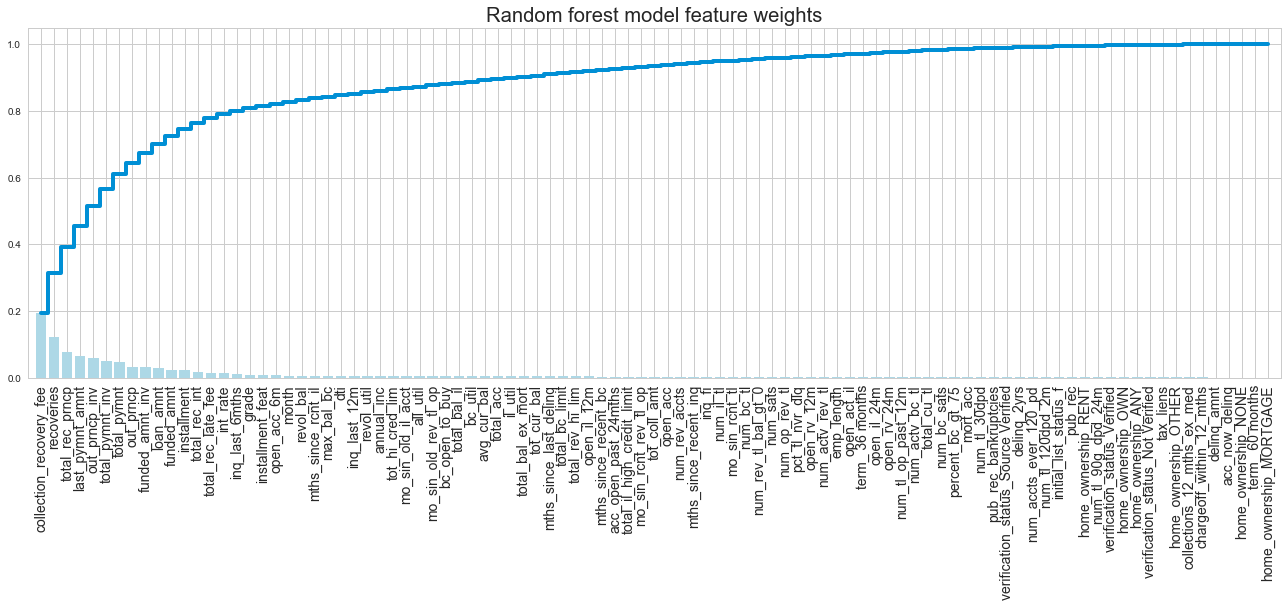

In [369]:
importances = get_feature(X,X_feature,y,10)

In [390]:
#输出权重
im = list(importances)
im = [i*100 for i in im]
feature = list(X_feature)[:-1]
c = {"feature":feature, "importances":im}
df = pd.DataFrame(c)
df[df.importances>1]

,feature,importances
0,loan_amnt,2.761047
1,funded_amnt,2.289417
2,funded_amnt_inv,3.132595
3,int_rate,1.291350
4,installment,2.162886
17,out_prncp,3.207864
18,out_prncp_inv,5.961112
19,total_pymnt,4.634393
20,total_pymnt_inv,4.914614
21,total_rec_prncp,7.735474


In [391]:
#迭代特征选择---递归特征消除
def model_select(X,y,n):
    from sklearn.feature_selection import RFE
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=10,random_state=42)
    rfe = RFE(model,n) #留n个特征
    model = rfe.fit(X,y)
    return model.support_

In [392]:
#通过特征权重分析可知, 权重大于1%的特征只有15个
new_feature = X_feature[model_select(X,y,15)]
new_feature

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'max_bal_bc', 'month'],
      dtype='object')

In [393]:
df_new = data[new_feature]
X_new = Imputer().fit_transform(df_new)

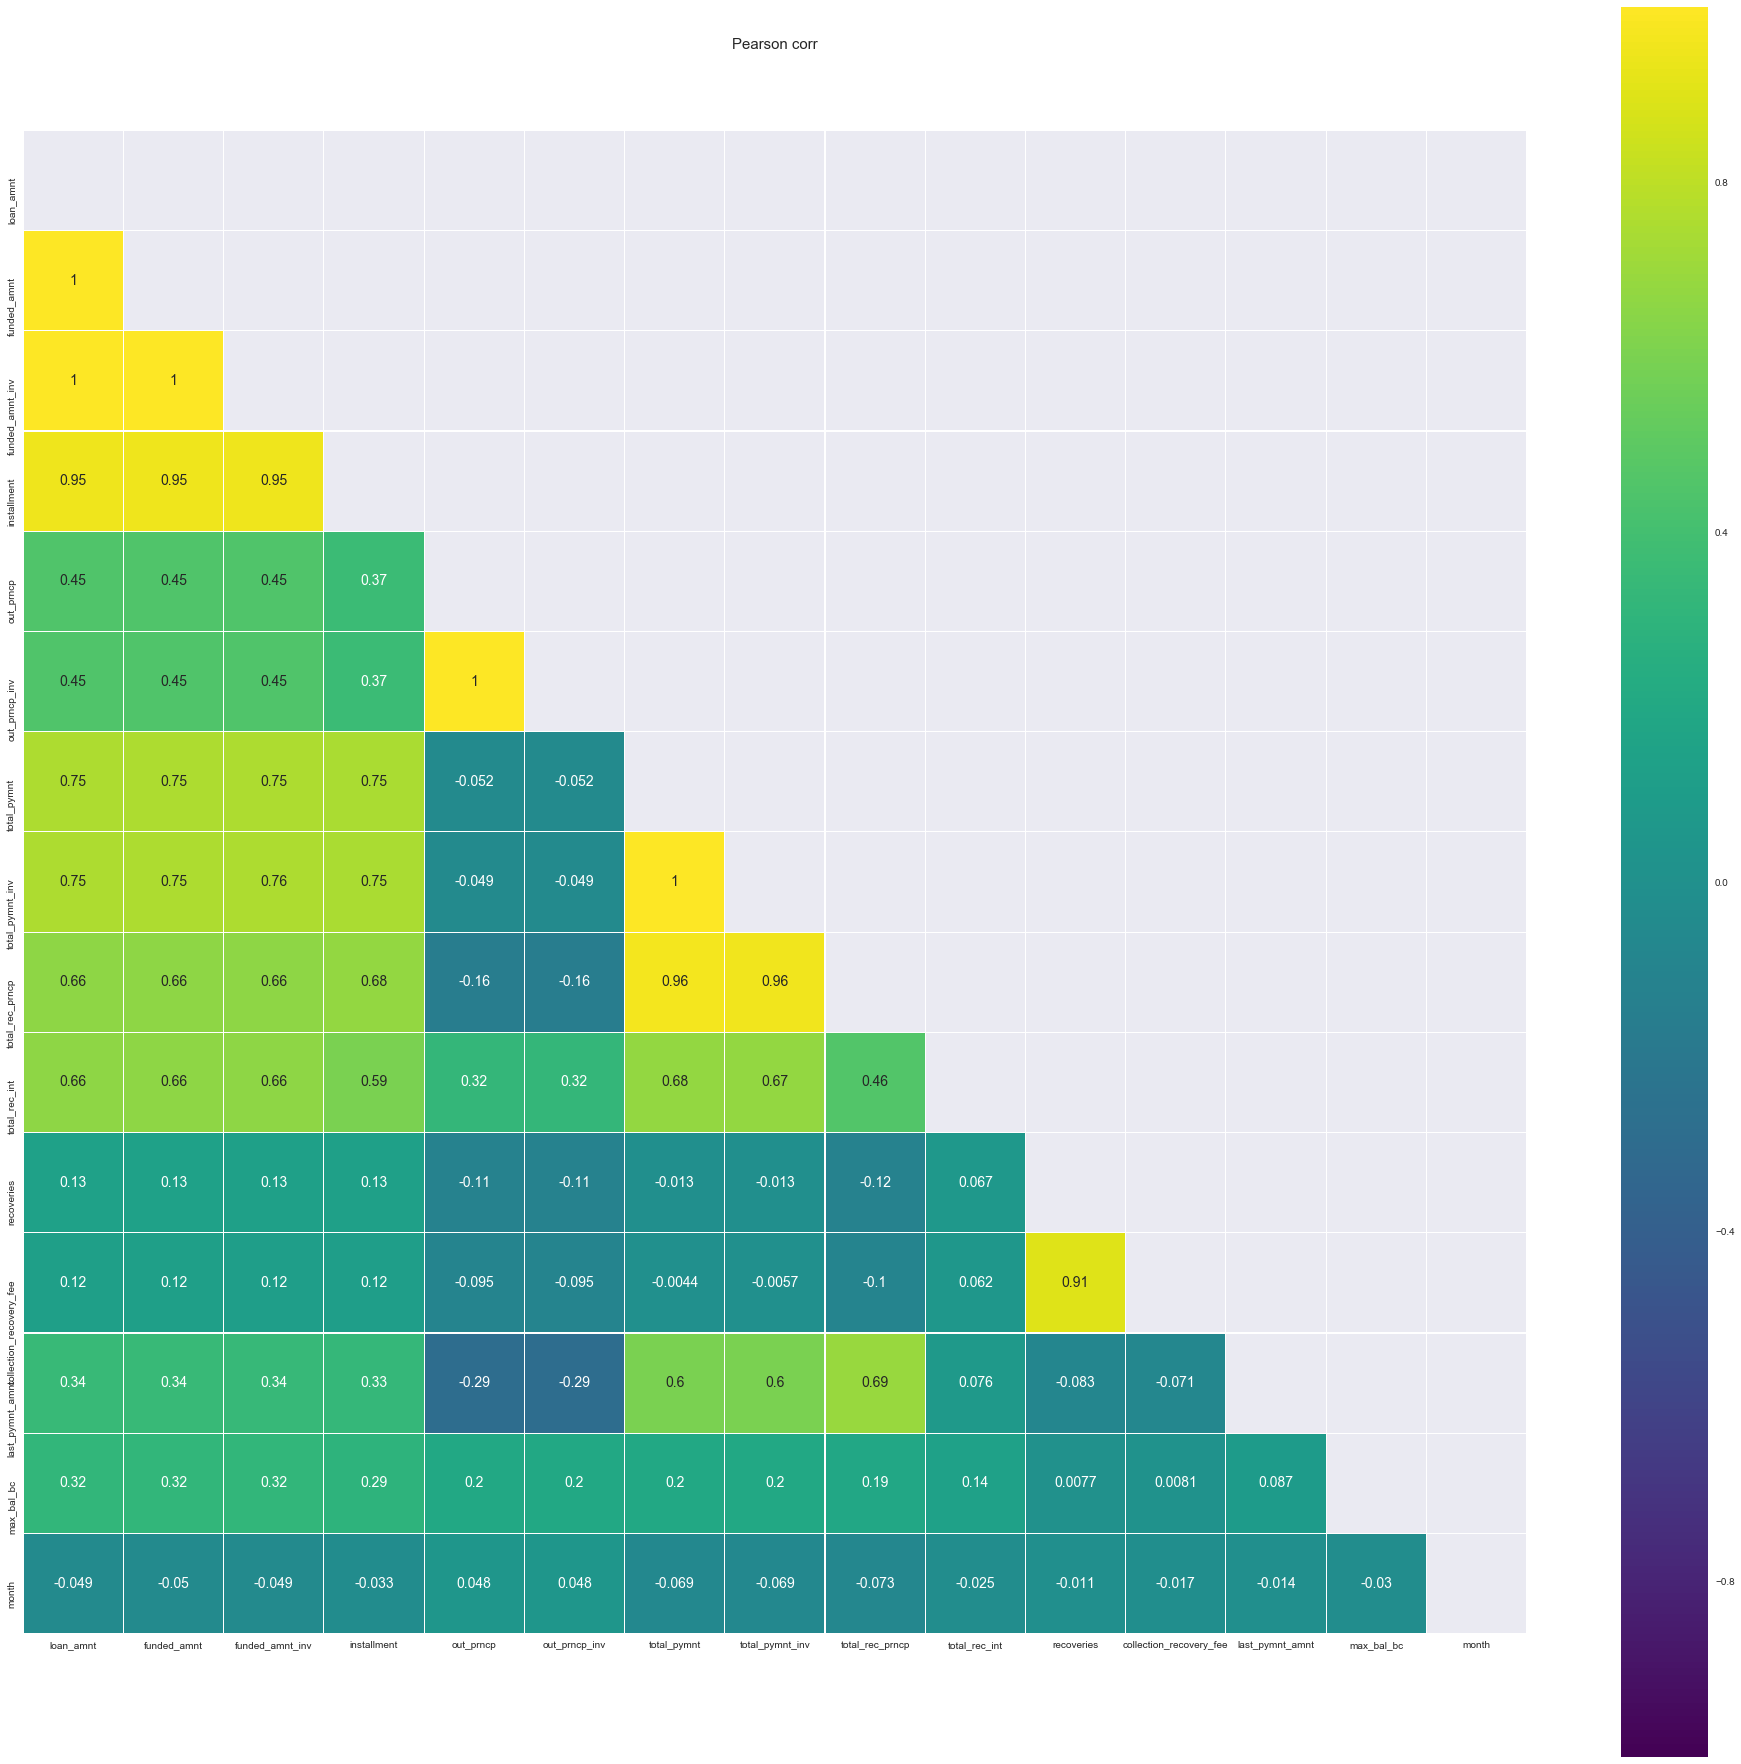

In [394]:
#皮尔森相关系数
colormap = plt.cm.viridis
plt.figure(figsize=(30,30))
sns.set_style("dark",{"font.sans-serif":["simhei","Arial"]})
plt.title('Pearson corr', y=1.05, size=15)
mask = np.zeros_like(df_new.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_new.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True,mask=mask)

In [403]:
#删除相关性较大的特征
drop_columns = ['funded_amnt', 'funded_amnt_inv', 'installment','out_prncp_inv','total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int','collection_recovery_fee', 'last_pymnt_amnt']
new_feature = list(new_feature)
new_feature = [x for x in new_feature if x not in drop_columns]

In [404]:
df_last = data[new_feature]
X = Imputer().fit_transform(df_last)

In [412]:
#保存清洗后的数据
last_columns = new_feature+["loan_status"]
df = data[last_columns]
df.to_csv("data_last.csv",encoding="utf-8",index=False)

In [3]:
data = pd.read_csv("data_last.csv",encoding="utf-8")
X=data.drop("loan_status",axis=1)
y = pd.DataFrame(data["loan_status"],columns=["loan_status"])

feature_name = list(X.columns)
target_name = ["loan_status"]

from sklearn.preprocessing import Imputer
X = Imputer().fit_transform(X)
y = Imputer().fit_transform(y)

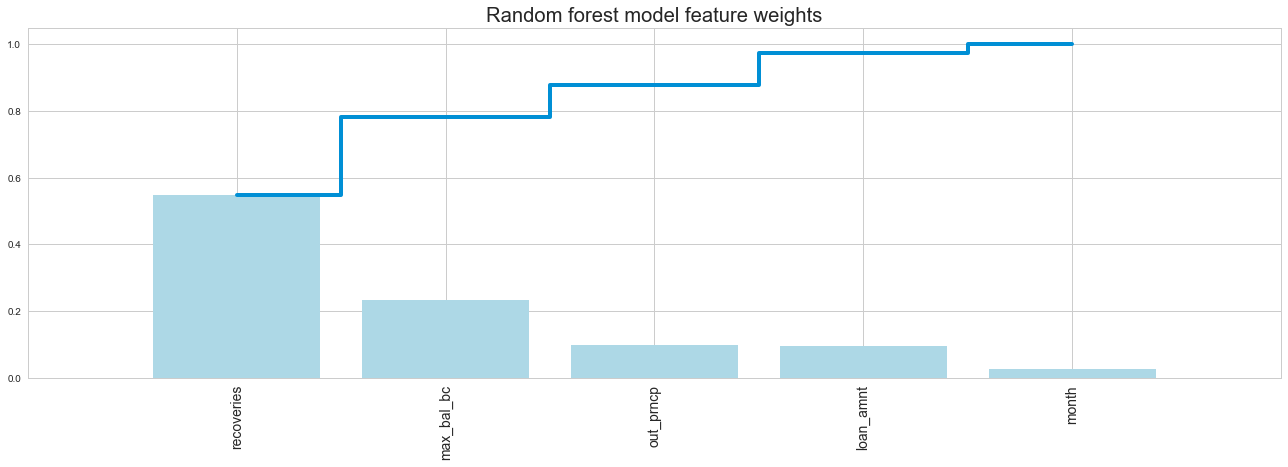

In [415]:
#再次查看各特征权重
importances = get_feature(X,y,data[new_feature].columns,10)

## 构建模型

In [4]:
#处理不平衡样本
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_Last,y_Last = ros.fit_sample(X,y)

In [5]:
#数据拟合
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train,X_test,y_train,y_test = train_test_split(X_Last,y_Last,test_size=0.3,random_state=0)

model = LogisticRegression()
model = model.fit(X_train,y_train)

auc_score = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
print("AUC分数:",auc_score)

AUC分数: 0.78695002112


In [8]:
#交叉验证
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.model_selection import KFold 
kfold = KFold(n_splits=10) #可以通过kfold(交叉验证分离器)来控制cv参数
LG = LogisticRegression()

scores = cross_val_score(LG,X_Last,y_Last,cv=kfold) #cv是折数参数, 默认值为3
print("mean_Accuracy",scores.mean())

mean_Accuracy 0.713394722308


## 模型优化

In [6]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import  train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV #估计器

x_train,x_test,y_train,y_test = train_test_split(X_Last,y_Last,random_state=0,test_size=0.3)

#构建参数组集
param_grid ={"penalty": ["l1","l2"],"C":[0.001,0.1,10,100]}

#构建网络搜索分类器
lg = LogisticRegression()
kfold = KFold(n_splits=5)
grid_search = GridSearchCV(lg,param_grid=param_grid, cv=kfold)

#数据拟合
grid_search.fit(x_train,y_train)
#模型AUC值
roc_auc_score(y_test,grid_search.predict_proba(X_test)[:,1])

0.78695004035278526

In [9]:
#输出各项参数
import time
clock = time.time()
from sklearn.metrics import confusion_matrix #混淆矩阵
from sklearn.metrics import classification_report #输出混淆矩阵各项指标

#输出混淆矩阵及各项指标
pred = grid_search.predict(x_test)
confusion = confusion_matrix(y_test,pred)
print(confusion)
#输出准确率,召回率,f1值,数量
print(classification_report(y_test,pred,target_names =["正常","欺诈"]))

#输出最佳参数
print("最佳参数组合: {}".format(grid_search.best_params_))
print("最佳交叉验证分数: {:.5f}".format(grid_search.best_score_))
print("用时:",time.time()-clock)

[[169562   1917]
 [ 85921  86300]]
             precision    recall  f1-score   support

         正常       0.66      0.99      0.79    171479
         欺诈       0.98      0.50      0.66    172221

avg / total       0.82      0.74      0.73    343700

最佳参数组合: {'C': 0.1, 'penalty': 'l2'}
最佳交叉验证分数: 0.74411
用时: 0.6333696842193604


In [423]:
#重新拟合模型
t0 = time.clock()
model = LogisticRegression(penalty="l2",C=0.1)
model = model.fit(X_train,y_train)

auc_score = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
print("AUC分数:",auc_score)
print("用时:",time.clock()-t0)

AUC分数: 0.786164655354
用时: 4.649295999999595


In [430]:
model.score(X_test,y_test)

0.74279895257492001

AUC分数: 0.78695002112


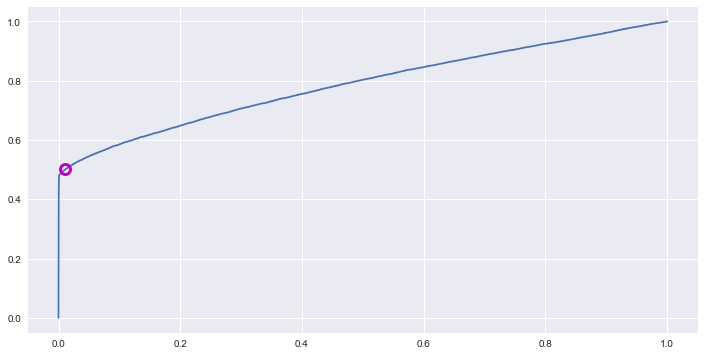

In [11]:
#新模型评估
from sklearn.metrics import roc_curve #ROC曲线

fpr_rf,tpr_rf,thresholds = roc_curve(y_test,model.predict_proba(x_test)[:,1])

#找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds-0.5))
plt.figure(figsize=(12,6))
plt.plot(fpr_rf,tpr_rf,label="ROC")
plt.plot(fpr_rf[close_zero],tpr_rf[close_zero],"o",markersize=10,label="threshold 0.5rf",fillstyle="none",c="m",mew=3)
#打印AUC分数
rf_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:,1])
print("AUC分数:",rf_auc)

Text(0.5,1,'KS curve')

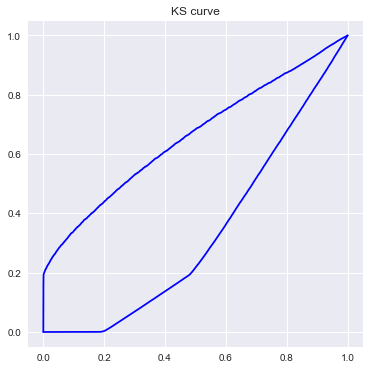

In [24]:
#KS曲线
fpr_test,tpr_test,th_test = roc_curve(y_test,model.predict_proba(x_test)[:,1])

test_x_axis = np.arange(len(fpr_test))/float(len(fpr_test))

plt.figure(figsize=[6,6])
plt.plot(fpr_test, test_x_axis, color="b")
plt.plot(tpr_test, test_x_axis, color="b")
plt.title('KS curve')

In [25]:
KS = max(abs(fpr_test-tpr_test))
KS

0.49634259418071797